# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, os
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from keras.utils import pad_sequences

# Dataset

In [ ]:
data = pd.read_csv('train-balanced-sarcasm-50k.csv')
data.head()

,label,comment
0,1,Yes that's why I don't advocate for the rights...
1,1,I can find you a Pinsir if you want one that bad.
2,0,"Huh, that's pretty interesting actually thanks..."
3,1,TIL a monsoon = average summer weather in Sweden
4,1,Yeah everyone knows holographic tigers and bom...


In [ ]:
data.dropna(inplace=True)
data.isnull().sum()

label      0
comment    0
dtype: int64

# Data Preprocessing

### Stopwords and Punctuation

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopword.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def remove_emoji(text):
    text = emoji.sub(r'', text)
    return text

def html_cleaning(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_squarebracket(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_stopwordspunct(text):
    clean_text = []
    for i in text.split():
        if i.strip().lower() not in stopword:
            clean_text.append(i.strip())
    return ' '.join(clean_text)

def fix_word(text):
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    return text

def preprocess_text(text):
    text = remove_emoji(text)
    text = html_cleaning(text)
    text = remove_squarebracket(text)
    text = remove_stopwordspunct(text)
    text = fix_word(text)
    return text

data['comment'] = data['comment'].apply(preprocess_text)

<ipython-input-10-80ca9e38dc6c>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
data.head(10)

,label,comment
0,1,Yes that is advocate rights people can not pos...
1,1,find Pinsir want one bad.
2,0,"Huh, that is pretty interesting actually thank..."
3,1,TIL monsoon average summer weather Sweden
4,1,Yeah everyone knows holographic tigers bombs c...
5,0,4 polish portuguese team.. feels good worry much
6,1,"Reading guy makes want hear Donald Trump, relate."
7,0,loulex UOL 100% confirmed
8,1,Pray death!
9,0,like they are setting put football games jumbo...


# Modeling WORD2VEC

### Converting words / text to input acceptable to model

In [ ]:
words = []
for i in data.comment.values:
    words.append(i.split())
words[:5]

[['Yes',
  'that',
  'is',
  'advocate',
  'rights',
  'people',
  'can',
  'not',
  'possibly',
  'understand',
  'particularly',
  'fond',
  'of..'],
 ['find', 'Pinsir', 'want', 'one', 'bad.'],
 ['Huh,',
  'that',
  'is',
  'pretty',
  'interesting',
  'actually',
  'thanks',
  'insight.'],
 ['TIL', 'monsoon', 'average', 'summer', 'weather', 'Sweden'],
 ['Yeah',
  'everyone',
  'knows',
  'holographic',
  'tigers',
  'bombs',
  'can',
  'not',
  'possibly',
  'coexist',
  'side',
  'side!']]

### Model

In [ ]:
import gensim
EMBEDDING_DIM = 200
word2vec = gensim.models.Word2Vec(sentences=words, vector_size = EMBEDDING_DIM, window=5, min_count=1)

### Vocabulary Size

In [ ]:
vocab_size = len(word2vec.wv.key_to_index)
vocab_size

67327

In [ ]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 20)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

### Weight Matrix

In [ ]:
def weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, model.vector_size))

    for word, i in vocab.items():
        if word in model.wv.key_to_index:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

#Embedding Vector
embedding_vectors = weight_matrix(word2vec, tokenizer.word_index)

# Training Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def train_or_load_model(model_file, x_train, y_train, x_test, y_test):
    if os.path.exists(model_file):
        model = tf.keras.models.load_model(model_file)
        print("Model loaded successfully.")
    else:
        model_checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', save_best_only=True)
        early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
        lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

        model = Sequential()
        model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))

        # LSTM
        model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))

        # GRU
        model.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))

        # Dense Output Layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile Model
        model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=64,
                            callbacks=[early_stop, lr_reduction, model_checkpoint])

        # Plotting
        epoch = [i for i in range(len(history.history['accuracy']))]
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(20, 6)

        ax[0].plot(epoch, history.history['loss'], label='Training Loss')
        ax[0].plot(epoch, history.history['val_loss'], label='Testing Loss')
        ax[0].set_title('Training & Testing Loss')
        ax[0].legend()
        ax[0].set_xlabel('Epochs')

        ax[1].plot(epoch, history.history['accuracy'], label='Training Accuracy')
        ax[1].plot(epoch, history.history['val_accuracy'], label='Testing Accuracy')
        ax[1].set_title('Training & Testing Accuracy')
        ax[1].legend()
        ax[1].set_xlabel('Epochs')

        plt.show()

    print('Model Accuracy: ', model.evaluate(x_test, y_test)[1])

    return model

### Splitting Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, data.label , test_size = 0.2 , random_state = 0)

### Training

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6152

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 159s 232ms/step - loss: 0.6473 - accuracy: 0.6152 - val_loss: 0.6113 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 127s 203ms/step - loss: 0.4732 - accuracy: 0.7726 - val_loss: 0.6679 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 126s 202ms/step - loss: 0.3199 - accuracy: 0.8530 - val_loss: 0.8235 - val_accuracy: 0.6321 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.8895
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 126s 202ms/step - loss: 0.2407 - accuracy: 0.8895 - val_loss: 1.0448 - val_accuracy: 0.6268 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 126s 201ms/step - loss: 0.1796 - accuracy: 0.9180 - val_loss: 1.3188 - val_accuracy: 0.6228 - lr: 5.0000e-04
Epoch 6/50
625/625 [==============================]

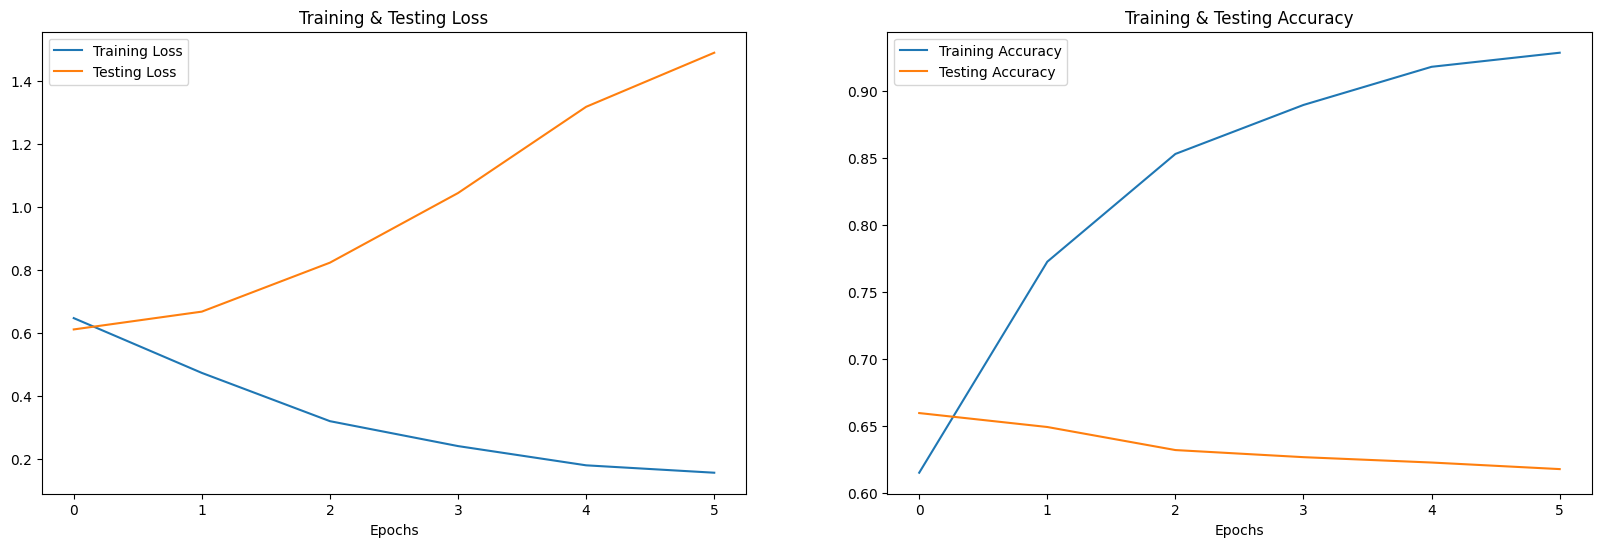

313/313 [==============================] - 7s 23ms/step - loss: 0.6113 - accuracy: 0.6597
Model Accuracy:  0.6596999764442444


In [ ]:
model_file = 'glovemodel.h5'
trained_model = train_or_load_model(model_file, x_train, y_train, x_test, y_test)

### Plotting Evaluation

313/313 [==============================] - 9s 28ms/step


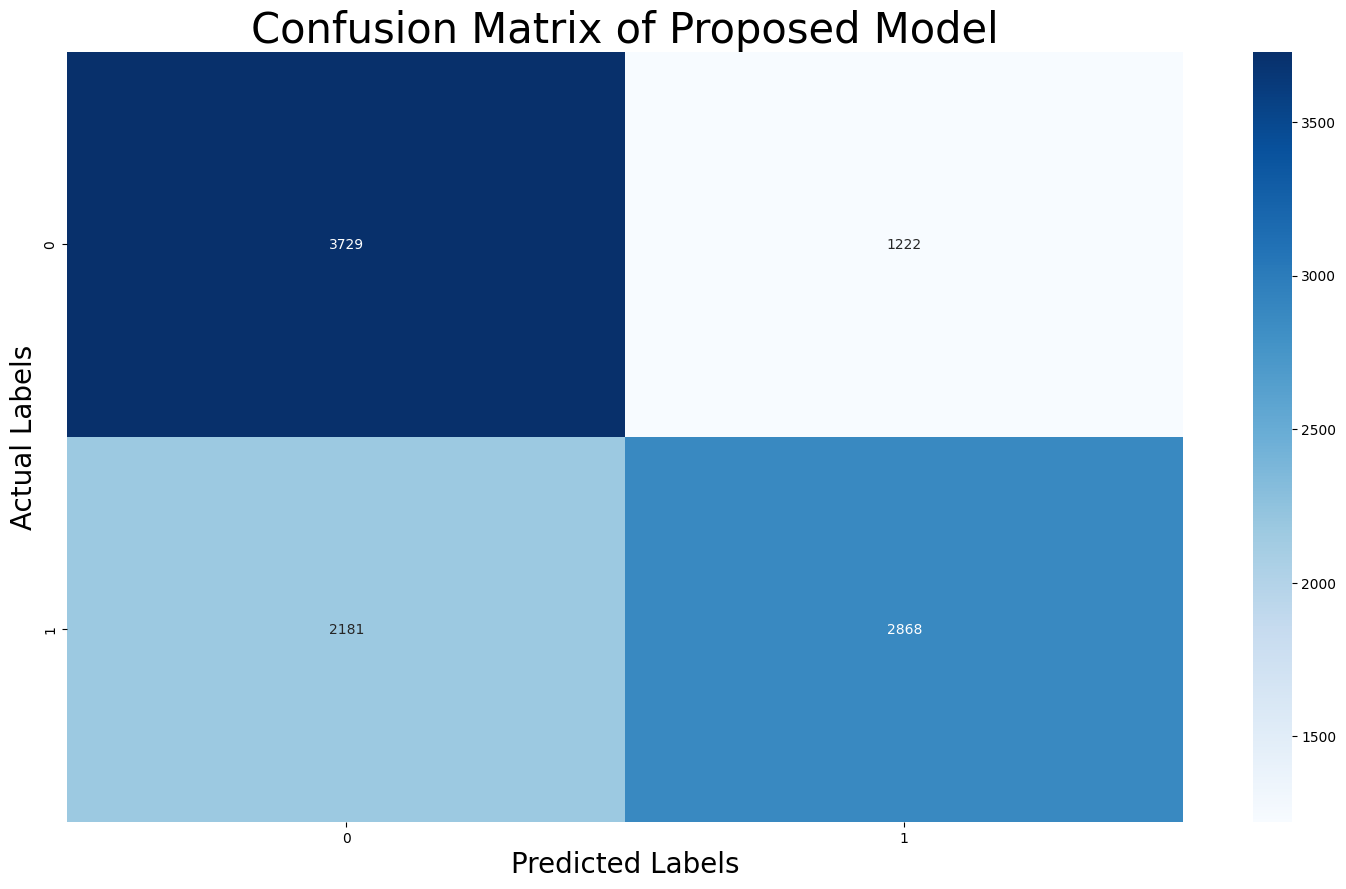

              precision    recall  f1-score   support

           0       0.63      0.75      0.69      4951
           1       0.70      0.57      0.63      5049

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



In [ ]:
pred = trained_model.predict(x_test)

threshold = 0.5
pred_labels = (pred > threshold).astype(int)
cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(18, 10))
cm_df = pd.DataFrame(cm, index=[i for i in range(cm.shape[0])], columns=[i for i in range(cm.shape[1])])
sns.heatmap(cm_df, cmap='Blues', annot=True, fmt='.0f', linecolor='white')
plt.title('Confusion Matrix of Proposed Model', size=30)
plt.xlabel('Predicted Labels', size=20)
plt.ylabel('Actual Labels', size=20)
plt.show()


print(classification_report(y_test, pred_labels))

### Confusion Matrix

In [ ]:
pred_probabilities = model.predict(x_test)
threshold = 0.7
pred = (pred_probabilities > threshold).astype(int)
print(pred)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
display_labels = [0, 1]
cm = confusion_matrix(y_test,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.show()